# SCS 3546 Deep Learning Week 3

# Convolutional Neural Networks


 # Learning Objectives

- Understanding of:
    - Where CNNs came from
    - What CNNs building blocks look like
    - How to implement them using TensorFlow and Keras. 
- Exposure to the theory and code to train, and evalute CNNs
- Appreciate diverse number of applications with CNNs
- Grasp practical considerations: memory, training time, parameters 
- Review and study the most important CNNs architectures:
    - LeNet-5, AlexNet, GoogLeNet, ResNet
- Use MNIST as sandbox to understand different levels of abtractions of the CNNs

# Introduction

- Convolutional neural networks (CNNs) emerged from the study of the brain’s visual cortex, and they have been used in image recognition since the 1980s. 

- In the last few years, thanks to the increase in computational power, the amount of available training data, and better training techniques for deep nets, CNNs have managed to achieve superhuman performance. 

- They power image search services, self-driving cars, automatic video classification systems, and more. They are also successful at other tasks, such as voice recognition or natural language processing.

- Today we will present where CNNs came from, what their building blocks look like, and how to implement them using TensorFlow.

# Setup

First, let's make sure this notebook has all the required libraries, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import os

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

#Import tensorflow
import tensorflow as tf
from tensorflow import keras  
from tensorflow.keras import layers  


# Data Preprocessing


![alt text](http://ai.stanford.edu/~syyeung/cvweb/Pictures1/imagematrix.png)

Ref: http://ai.stanford.edu/~syyeung/cvweb/tutorial1.html

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our network. Currently, our data sits on a drive or a directory on cloud as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit too much, but you can do it all with Keras

[source](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb)

### Reading image data into your workspace

Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-07-27 15:31:50--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   134MB/s    in 0.5s    

2021-07-27 15:31:50 (134 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets (see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) for a refresher on training, validation, and test sets), which in turn each contain `cats` and `dogs` subdirectories. Let's define each of these directories:

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.929.jpg', 'cat.704.jpg', 'cat.894.jpg', 'cat.139.jpg', 'cat.107.jpg', 'cat.39.jpg', 'cat.331.jpg', 'cat.24.jpg', 'cat.591.jpg', 'cat.497.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

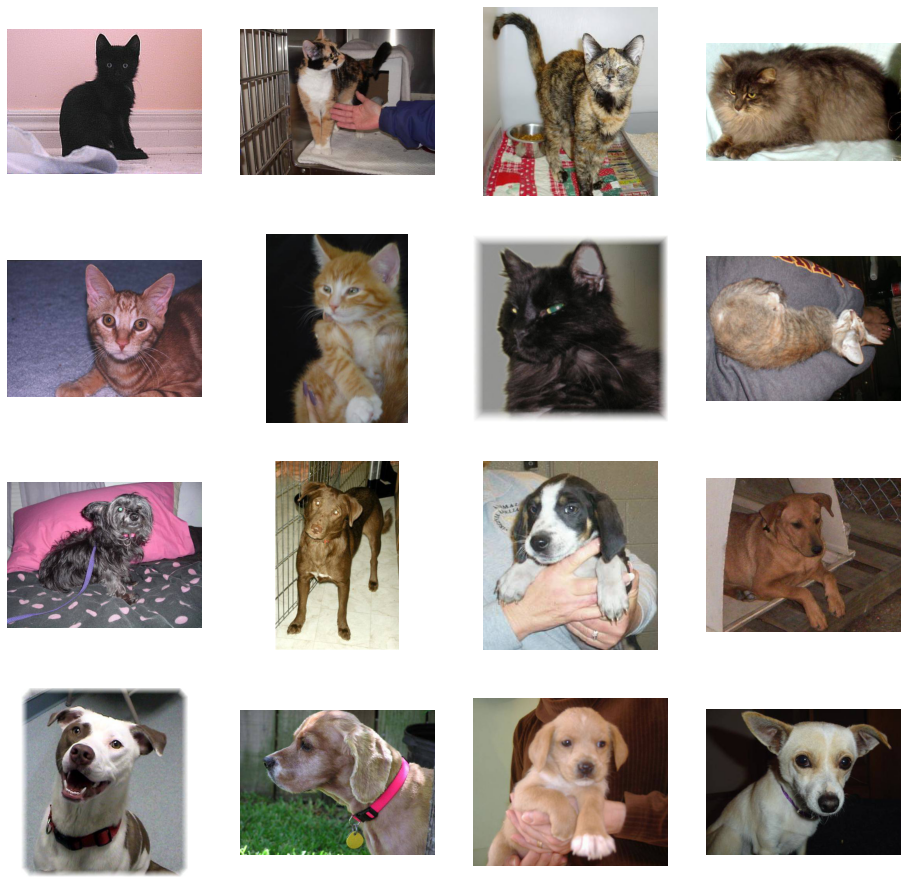

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


### Loading images by using `image_dataset_from_directory`

For demonstrating using `image_dataset_from_directory` we are using flower dataset which is about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class. By using following code, we can download the data 

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


By using following code we can view each of the images

In [ ]:
import PIL

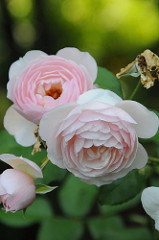

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

Let's load these images off disk using the helpful image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code.

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## Data Augmentation


Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better.



#### ImageDataGenerator

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our ImageDataGenerator instance. Please look into the following example

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.5,
      zoom_range=0.6,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* **rotation_range** is a value in degrees (0-180), a range within which to randomly rotate pictures.
* **width_shift** and **height_shift** are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* **shear_range** is for randomly applying shearing transformations.
* **zoom_range** is for randomly zooming inside pictures.
* **horizontal_flip** is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal asymmetry (e.g. real-world pictures).
* **fill_mode** is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [ ]:
train_generator = datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 2000 images belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
    


data batch shape: (20, 224, 224, 3)
labels batch shape: (20,)


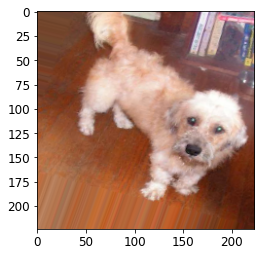

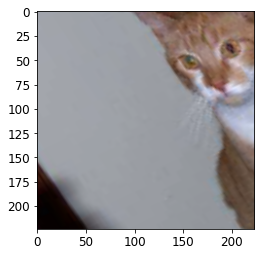

In [ ]:
# This is module with image preprocessing utilities
from tensorflow.keras.preprocessing import image
i = 0
for batch in train_generator:
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0][0]))
    i += 1
    if i % 2 == 0:
        break

#### Preprocessing Layers 

You can use preprocessing layers for data augmentation as well.

Let's create a few preprocessing layers and apply them repeatedly to the same image.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
for x in train_ds.take(1):
 images, labels = x

#pick a random image
image_index=14


In [ ]:
# Add the image to a batch
image = tf.expand_dims(images[image_index], 0)

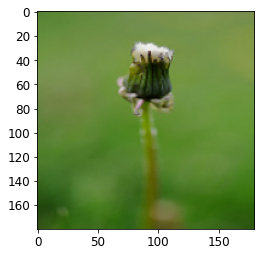

In [ ]:
plt.imshow(images[image_index].numpy().astype("uint8"))

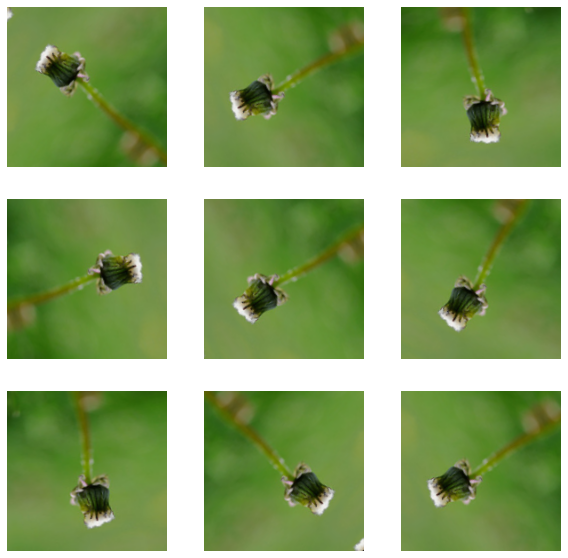

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

#  Convolution Matrix

In image processing, a **kernel**, **convolution matrix**, or **mask** is a small matrix. It is used for blurring, sharpening, embossing, edge detection, and more. This is accomplished by doing a convolution between a kernel and an image.

$$
\left[\begin{array}{cccc}{x_{11}} & {x_{12}} & {\cdots} & {x_{1 n}} \\ {x_{21}} & {x_{22}} & {\cdots} & {x_{2 n}} \\ {\vdots} & {\vdots} & {\ddots} & {\vdots} \\ {x_{m 1}} & {x_{m 2}} & {\cdots} & {x_{m n}}\end{array}\right] *\left[\begin{array}{cccc}{y_{11}} & {y_{12}} & {\cdots} & {y_{1 n}} \\ {y_{21}} & {y_{22}} & {\cdots} & {y_{2 n}} \\ {\vdots} & {\vdots} & {\ddots} & {\vdots} \\ {y_{m 1}} & {y_{m 2}} & {\cdots} & {y_{m n}}\end{array}\right]=\sum_{i=0}^{m-1} \sum_{j=0}^{n-1} x_{(m-i)(n-j)} y_{(1+i)(1+j)}
$$

![alt text](https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/keras-conv2d/keras_conv2d_padding.gif)

[ref: https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/]


<img src="https://drive.google.com/uc?id=1d-MGBSEthITcBGEuuIw2cGJEY_SuUJ_X">
    

# Architecture of the Visual Cortex

- David H. Hubel and Torsten Wiesel performed a series of experiments on cats in 1958 and 1959 giving crucial insights on the structure of the visual cortex. (Nobel Prize in Medicine in 1981). 
- They showed that many neurons in the visual cortex have a small local receptive field:
    - The receptive fields of different neurons may overlap, and together they tile the whole visual field. 
    - They showed that some neurons react only to images of horizontal lines, while others react only to lines with different orientations. 
    - They also noticed that some neurons have larger receptive fields, and they react to more complex patterns that are combinations of the lower-level patterns. 
- Their observations led to the idea that the higher-level neurons are based on the outputs of neighboring lower-level neurons

<img src="https://drive.google.com/uc?id=18xe2XergIDJLRkQXpoZhVE42XJJ6WAeu">


# Why Not a Fully Connected Network?

- This approach works well for small images (e.g., MNIST), however it breaks for larger images due to the large number of parameters required. 
    - For example, a 100 × 100 image has 10,000 pixels,
    - If the first layer has just 1,000 neurons this means a total of 10 million connections,
    - And that’s just the first layer!
- CNNs solve this problem using partially connected layers.

# Convolutional Layer

- Neurons in the first convolutional layer are not connected to every single pixel in the input image. The neurons are only connected to pixels in their receptive fields.


<img src="https://drive.google.com/uc?id=1jH-_bIk1h4t20f7EY8Xm5PxYNqH2PkZB">


- In turn, each neuron in the second convolutional layer is connected only to neurons located within a small rectangle in the first layer. 


- This architecture allows the network to concentrate on low-level features in the first hidden layer, then assemble them into higher-level features in the next hidden layer, and so on. 


- A neuron located in row $i$, column $j$ of a given layer is connected to the outputs of the neurons in the previous layer located in rows $i$ to $i + f_h – 1$, columns $j$ to $j + f_w – 1$. 


### Connections between layers and zero padding


- In order for a layer to have the same height and width as the previous layer, it is common to add zeros around the inputs.

<img src="https://drive.google.com/uc?id=17mCgpukYy2wzoHjvNbhRawmU29HzKX3b">






## Stride

- It is also possible to connect a large input layer to a much smaller layer by spacing out the receptive fields. The distance between two consecutive receptive fields is called the stride. 



##### A 5 × 7 input layer (plus zero padding) is connected to a 3 × 4 layer, using 3 × 3 receptive fields and a stride of two. 

<img src="https://drive.google.com/uc?id=14bu_nmar0nhBfdhpG6syzJJ3xEjJKymK">

- By using a stride greater than one, the dimentionality of the layer can be reduced.

## Filters

- A neuron’s weights can be represented as a small image the size of the receptive field. 
    - Example: Two possible sets of weights, called filters (or convolution kernels). 
        - The first one is represented as a black square with a vertical white line in the middle. Neurons using these weights will ignore everything in their receptive field except for the central **vertical** line 
        - The second filter is a black square with a horizontal white line in the middle. Neurons using these weights will ignore everything in their receptive field except for the central **horizontal** line.

<img src="https://drive.google.com/uc?id=15In-zV9iGufEaNGI-pbs1r1Sz8OMnnin">

- A layer full of neurons using the same filter gives you a feature map, which highlights the areas in an image that are most similar to the filter. 
    - If all neurons in a layer use the same vertical line filter, the layer output  will enhance the white vertical lines, the rest gets blurred. 
    - Similarly, for the horizontal line filter. 
- During training, a CNN finds the most useful filters for its task, and it learns to combine them into more complex patterns 

## Stacking Multiple Feature Maps

- CNN can be composed of several feature maps of equal sizes, so it is more accurately represented in 3D. 
    - Within one feature map, all neurons share the same parameters 
    - A convolutional layer simultaneously applies multiple filters to its inputs, making it capable of detecting multiple features anywhere in its inputs.
    - Since a feature map shares the same parameters dramatically reduces the number of parameters in the model, but most importantly it means that once the CNN has learned to recognize a pattern in one location, it can recognize it in any other location. 
    - Input images are also composed of multiple sublayers: one per color channel.
    

<img src="https://drive.google.com/uc?id=1z6JBdtnJKqT9LdJcpZ_5O2V-ZQ3ck-D9">



- A neuron located in row $i$, column $j$ of the feature map $k$ in a given convolutional layer $l$ is connected to the outputs of the neurons in the previous layer $l – 1$, located in rows $i × s_h$ to $i × s_h + f_h – 1$ and columns $j × s_w$ to $j × s_w + f_w – 1$, across all feature maps (in layer $l – 1$).

$$
z_{i, j, k}=b_{k}+\sum_{u=0}^{f_{h}-1} \sum_{v=0}^{f_{v}-1} \sum_{k=0}^{f_{f}-1} x_{i^{\prime}, j^{\prime}, k^{\prime}} w_{u, v, k^{\prime}, k} \quad \text { with }\left\{\begin{array}{l}{i^{\prime}=i \times s_{h}+u} \\ {j^{\prime}=j \times s_{w}+v}\end{array}\right.
$$

- $z_{i,j,k}$ is the output of the neuron located in row $i$, column $j$ in feature map $k$ of the convolutional layer (layer $l$).

- $s_h$ and $s_w$ are the vertical and horizontal strides, $f_h$ and $f_w$ are the height and width of the receptive field, and $f_n′$ is the number of feature maps in the previous layer (layer $l – 1$).

- $x_{i′, j′, k′}$ is the output of the neuron located in layer $l – 1$, row $i′$, column $j′$, feature map $k′$

- $b_k$ is the bias term for feature map $k$ (in layer $l$). 

- $w_{u, v, k′ ,k}$ is the connection weight between any neuron in feature map $k$ of the layer $l$ and its input located at row $u$, column $v$, and feature map $k′$.

# Tensorflow Implementation

- In TensorFlow, each input image is typically represented as a 3D tensor of shape [height, width, channels]. 
- A mini-batch is represented as a 4D tensor of shape [mini-batch size, height, width, channels]. 
- The weights of a convolutional layer are represented as a 4D tensor of shape [fh, fw, fn′, fn]. The bias terms of a convolutional layer are simply represented as a 1D tensor of shape [fn].

The following code loads two sample images. Then it creates two 7 × 7 filters, and applies them to both images using a convolutional layer built using TensorFlow’s tf.nn.conv2d() function 

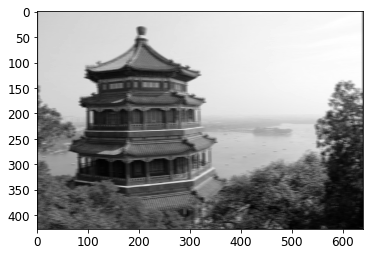

In [ ]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

### TF Padding

- Padding must be either "VALID" or "SAME":

    - If set to "VALID", the convolutional layer does not use zero padding, and may ignore some rows and columns at the bottom and right of the input image.
    - If set to "SAME", the convolutional layer uses zero padding if necessary.
    
    
    
<img src="https://drive.google.com/uc?id=1Knike3qXCgi-Rzwrb7H8G1zNy7EAaf6Q">
    
    

### - Convolutional layers have several hyperparameters: 
    - Number of filters,
    - Filter height and width, 
    - Strides, 
    - and the padding type. 
- One can use cross-validation to find the right hyperparameter values, but this is very time-consuming.

## Memory requirements

- Convolutional layers require a huge amount of RAM, especially during training, because the reverse pass of backpropagation requires all the intermediate values computed during the forward pass.

Example: A convolutional layer with 5 × 5 filters, outputting 200 feature maps of size 150 × 100, with stride 1 and SAME padding. 
- If the input is a 150 × 100 RGB image (three channels), then the number of parameters is (5 × 5 × 3 + 1) × 200 = 15,200 
- However, each of the 200 feature maps contains 150 × 100 neurons, and each of these neurons needs to compute a weighted sum of its 5 × 5 × 3 = 75 inputs: that’s a total of 225 million float multiplications. 
- If the feature maps are represented using 32-bit floats, then the convolutional layer’s output will occupy 200 × 150 × 100 × 32 = 96 million bits (about 11.4 MB) of RAM.
- If a training batch contains 100 instances, then this layer will use up over 1 GB of RAM!

If training crashes because of an out-of-memory error, try:
- reducing the mini-batch size,
- reducing dimensionality using a stride, 
- remove a few layers,
- use 16-bit floats instead of 32-bit floats,
- distribute the CNN across multiple devices.

# Pooling layer

- Their goal is to subsample the input image in order to reduce the computational load, memory usage, and number of parameters
- Each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a small rectangular receptive field
- Parameters: size, stride, and padding type. 
- Note that, a pooling neuron has no weights; it aggregates the inputs using a function such as the max or mean. 

<img src="https://drive.google.com/uc?id=1lOlduu3zlh1rqmgPngKfFG7ZzNXLURfL">

In this example, we use a 2 × 2 pooling kernel, a stride of 2, and no padding. max aggregation


- A small 2 × 2 kernel and a stride of 2. Will make the output two times smaller in both directions (so its area will be four times smaller).

- A pooling layer works on every input channel independently, so the output depth is the same as the input depth. 
- You may alternatively pool over the depth dimension.

The following code creates a max pooling layer using a 2 × 2 kernel, stride 2, and no padding, then applies it to all the images in the dataset:

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2, strides=2)

# Image Classification with Keras

Follow tutorial :


https://towardsdatascience.com/build-your-own-convolution-neural-network-in-5-mins-4217c2cf964f

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow import keras

In [ ]:
batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000,28,28,1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
#Build the network:

model = Sequential()
model.add(Conv2D(4, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(Conv2D(1, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 4)         40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 1)         37        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 1)         0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 144)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               18560     
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

469/469 [==============================] - 5s 4ms/step - loss: 2.7872 - accuracy: 0.6696 - val_loss: 0.4480 - val_accuracy: 0.8625
Test loss: 0.44800907373428345
Test accuracy: 0.862500011920929


### Exercise

Following Mnist Fashion dataset is downloaded, try to build a CNN to classifies the images




In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


4423680/4422102 [==============================] - 0s 0us/step


For training the network you need to change the shape of the input as well as rescaling. You can do these two tasks easily by using following layers in your code

```
    keras.layers.experimental.preprocessing.Rescaling(1./255),
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))
```

In [ ]:
### your code here 




In [ ]:
### your code here 




In [ ]:
### your code here 




In [ ]:
### your code here 




### Solution

In [ ]:
model = keras.models.Sequential([
    keras.layers.experimental.preprocessing.Rescaling(1./255),
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    keras.layers.Conv2D(64, 7, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same",),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same",),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same",),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same",),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(max(max(test_labels), max(train_labels))+1, activation='softmax')
])

In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
test_labels.shape

(10000,)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(train_images, train_labels, epochs=10, batch_size=128 , validation_data=(test_images, test_labels))


Epoch 1/10
469/469 [==============================] - 13s 24ms/step - loss: 0.6357 - accuracy: 0.7661 - val_loss: 0.3602 - val_accuracy: 0.8653
Epoch 2/10
469/469 [==============================] - 11s 23ms/step - loss: 0.3392 - accuracy: 0.8778 - val_loss: 0.3434 - val_accuracy: 0.8732
Epoch 3/10
469/469 [==============================] - 11s 23ms/step - loss: 0.2836 - accuracy: 0.8965 - val_loss: 0.2934 - val_accuracy: 0.8944
Epoch 4/10
469/469 [==============================] - 11s 22ms/step - loss: 0.2482 - accuracy: 0.9104 - val_loss: 0.2718 - val_accuracy: 0.9008
Epoch 5/10
469/469 [==============================] - 10s 22ms/step - loss: 0.2221 - accuracy: 0.9206 - val_loss: 0.2492 - val_accuracy: 0.9074
Epoch 6/10
469/469 [==============================] - 10s 22ms/step - loss: 0.1987 - accuracy: 0.9281 - val_loss: 0.2472 - val_accuracy: 0.9147
Epoch 7/10
469/469 [==============================] - 10s 22ms/step - loss: 0.1809 - accuracy: 0.9338 - val_loss: 0.2338 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


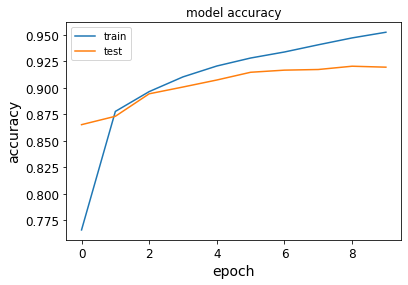

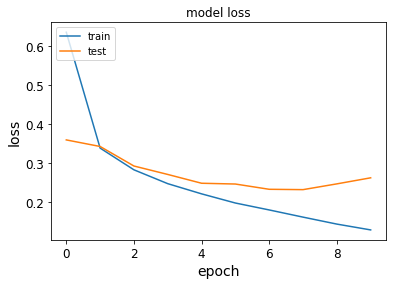

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# LeNet-5

It was created by Yann LeCun in 1998 and widely used for handwritten digit recognition (MNIST).

<img src="https://drive.google.com/uc?id=14CloqnMJUymq9nFluEiEKx2e5gy57acI">


- MNIST images are 28 × 28 pixels, but they are zero-padded to 32 × 32 pixels and normalized before being fed to the network. 

- For each neuron in the the pooling layer, it computes the mean of its inputs, then multiplies the result by a learnable coefficient (one per map) and adds a learnable bias term (again, one per map), then finally applies the activation function.

- Most neurons in C3 maps are connected to neurons in only three or four S2 maps 

- Output layer: each neuron outputs the square of the Euclidian distance between its input vector and its weight vector. Each output measures how much the image belongs to a particular digit class. 

[Yann LeCun’s website](http://yann.lecun.com/exdb/lenet/index.html) features great demos of LeNet-5 classifying digits.




# AlexNet

- The AlexNet CNN architecture won the 2012 ImageNet ILSVRC challenge:
    - It achieved 17% top-5 error rate while the second best achieved only 26%! 
- It was developed by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton. 
- It is quite similar to LeNet-5, only much larger and deeper, and it was the first to stack convolutional layers directly on top of each other, instead of stacking a pooling layer on top of each convolutional layer. 



<img src="https://drive.google.com/uc?id=1OKLgCmvQl8xF6eokb_tOnS6-CeKJlIeM">

- To reduce overfitting, the authors used two regularization techniques:
    - dropout (with a 50% dropout rate) during training to the outputs of layers F8 and F9. 
    - They performed data augmentation by randomly shifting the training images by various offsets, flipping them horizontally, and changing the lighting conditions.

- AlexNet also uses local response normalization immediately after the ReLU step of layers C1 and C3. This form of normalization makes the neurons that most strongly activate inhibit neurons at the same location but in neighboring feature maps.
    - This normalization encourages different feature maps to specialize, pushing them apart and forcing them to explore a wider range of features, ultimately improving generalization.

$$
b_{i}=a_{i}\left(k+\alpha \sum_{j=j_{\text {linw }}}^{j_{\text {high}}} a_{j}^{2}\right)^{-\beta} \text { with }\left\{\begin{array}{l}{j_{\text {high }}=\min \left(i+\frac{r}{2}, f_{n}-1\right)} \\ {j_{\text {low }}=\max \left(0, i-\frac{r}{2}\right)}\end{array}\right.
$$


- $b_i$ is the normalized output of the neuron located in feature map i, at some row u and column v.

- $a_i$ is the activation of that neuron after the ReLU step, but before normalization.

- $k, \alpha, \beta$ and $r$ are hyperparameters. $k$ is the bias, and $r$ is  the depth radius.

- $f_n$ is the number of feature maps.

- For example, if r = 2 and a neuron has a strong activation, it will inhibit the activation of the neurons located in the feature maps immediately above and below its own.

- In AlexNet, the hyperparameters are set as follows: $r = 2$, $\alpha = 0.00002$, $\beta = 0.75$, and $k = 1$. 

# GoogLeNet

- The GoogLeNet architecture was developed by Christian Szegedy et al. from Google Research.
- Increase in performace mainly comes from much deeper CNNs. 
- GoogLeNet uses sub-networks called inception modules(Think of it as an output feature maps that capture complex patterns at various scales), which allow GoogLeNet to use parameters much more efficiently than previous architectures:
    - GoogLeNet actually has 10 times fewer parameters than AlexNet.

Inception module. “3 × 3 + 2(S)” means that the layer uses a 3 × 3 kernel, stride 2, and SAME padding.
<img src="https://drive.google.com/uc?id=1AiQRlo_RwHPbrpetsiYxTv1OlDl5VuRZ">


- The input signal to the inception module is copied and fed to four different layers. 
- All convolutional layers use the ReLU activation function.
- The second set of convolutional layers uses different kernel sizes (1 × 1, 3 × 3, and 5 × 5), allowing them to capture patterns at different scales. 
- Every single layer uses a stride of 1 and SAME padding , so their outputs all have the same height and width as their inputs. This makes it possible to concatenate all the outputs along the depth dimension in the final depth concat layer 

- The 1 × 1 kernels, serve two purposes:

    - Dimentionality reduction: They are configured to output many fewer feature maps than their inputs, and 
    - Second, each pair of convolutional layers (`[1 × 1, 3 × 3]` and `[1 × 1, 5 × 5]`) acts like a single, powerful convolutional layer, capable of capturing more complex patterns. 

- The GoogLeNet CNN includes nine inception modules that actually contain three layers each. 
- The six numbers in the inception modules represent the number of feature maps output by each convolutional layer in the module. All the convolutional layers use the ReLU activation function.

<img src="https://drive.google.com/uc?id=1lvGmByHZBuKeVKHt4P3mocfdtiP1wryF">


- The first two layers divide the image’s height and width by 4.
- Then the local response normalization layer ensures that the previous layers learn a wide variety of features.
- Two convolutional layers follow, where the first acts like a bottleneck layer.
- Next a max pooling layer reduces the image height and width by 2, 
- Then comes the tall stack of nine inception modules, interleaved with a couple max pooling layers to reduce dimensionality.
- Next, the average pooling layer uses a kernel the size of the feature maps with VALID padding, outputting 1 × 1 feature maps. This makes it unnecessary to have several fully connected layers at the top of the CNN, considerably reducing the number of parameters in the network and limiting the risk of overfitting.
- The last layers are: dropout for regularization, then a fully connected layer with a softmax activation function to output estimated class probabilities.


Following we have access to `InceptionV3` model from `tf.keras.application`.

In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.applications.InceptionV3(weights="imagenet")
model.summary()

96116736/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________

# ResNet

- Developed by Kaiming He et al.: Extremely deep CNN composed of 152 layers. 
- Some of the connections are skipped (also called shortcut connections): the signal feeding into a layer is also added to the output of a layer located a bit higher up the stack. 

- What the residual part? 
    - When training a neural network, the target function is $h(x)$.
    - If we add the input $x$ to the output, then the network will be forced to model $f(x) = h(x) – x$. 
    This is called residual learning.

<img src="https://drive.google.com/uc?id=1vM5gPVeNU7f_7uT9H4XdY4sYmagLu_fn">



- When a neural network is initialized, its weights are close to zero. If we add a skip connection, the resulting network just outputs a copy of its inputs;
- If the target function is  close to the identity function, this will speed up training.

- With the skip connections, the network can start making progress even if some layers have not started learning yet 

Deep network vs ResNet
<img src="https://drive.google.com/uc?id=1p2-Zu2aKm4g47WH3vdSq4Vm-lijD4A0_">


- The networ starts and ends exactly like GoogLeNet, and in between a very deep stack of  residual units. 
- Each residual unit is composed of two convolutional layers, with Batch Normalization (BN) and ReLU activation.


<img src="https://drive.google.com/uc?id=1LqZyfMgjQxIGtOwBrq7M-sicVDpqQtg1">



- The number of feature maps is doubled every few residual units, at the same time as their height and width are halved. 

<img src="https://drive.google.com/uc?id=12eVy1QStz9_D2Cc-iyEJY_gRd6NGpUZ5">


- ResNet-34 is the ResNet with 34 layers,
    - It contains: three residual units that output 64 feature maps, 4 RUs with 128 maps, 6 RUs with 256 maps, and 3 RUs with 512 maps.

- ResNet-152, use diferent residual units, which have three convolutional layers: 
    - first a 1 × 1 convolutional layer with just 64 feature maps ,
    - then a 3 × 3 layer with 64 feature maps, 
    - and finally another 1 × 1 convolutional layer with 256 feature maps
    - ResNet-152 contains three such RUs that output 256 maps, then 8 RUs with 512 maps, a  36 RUs with 1024 maps, and finally 3 RUs with 2,048 maps.

- Other architectures to consider: 
    - VGGNet13 (runner-up of the ILSVRC 2014 challenge) 
    - Inception-v414 (which merges the ideas of GoogLeNet and ResNet and achieves close to 3% top-5 error rate on ImageNet classification)

Following you see sample implementation of Residual Unit in Keras

In [ ]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3],
                              padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

You can also access pretrained resnet model by using following command

In [ ]:
res_model = keras.applications.resnet50.ResNet50(weights="imagenet")
res_model.summary()

102973440/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

# Visualizing Intermediate Activations

Visualizing intermediate activations consists in displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its "activation", the output of the activation function). This gives a view into how an input is decomposed unto the different filters learned by the network. [source](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb)

<a id="s2"></a>
# Transfer Learning & Visual Feature Extraction

In the previous module we introduced __CNN__s and how they were used for classification of images in ImageNet dataset. We observed that training these complex nural networks required large number of images (e.g. ImageNet contains 1.2 million images with 1000 categories). However, in practice (e.g. classifying images not coming from ImageNet), almost nobody has access to that many images to train complex classifiers from scratch. Instead, it is common to pretrain a ConvNet (CNN) on a very large dataset (e.g. ImageNet), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest (e.g. classification). This method is called __Transfer Learning__. 

There are hree major Transfer Learning scenarios as follows:

- __ConvNet as a fixed feature extractor__: In this strategy, we take a ConvNet pretrained on ImageNet, remove the last fully-connected layer (this layer’s outputs are the 1000 class scores for a different task like ImageNet), then treat the rest of the ConvNet as a fixed feature extractor for the new dataset. In an AlexNet, this would compute a 4096-D vector for every image that contains the activations of the hidden layer immediately before the classifier. We call these features __CNN codes__. It is important for performance that these codes are ReLUd (i.e. thresholded at zero) if they were also thresholded during the training of the ConvNet on ImageNet (as is usually the case). Once we extract the 4096-D codes for all images, we can train a linear classifier (e.g. Linear SVM or Softmax classifier) for the new dataset.

<img src="https://qph.fs.quoracdn.net/main-qimg-9b3d3424df138ad5d7a87506dfddbc94">


<center>Source: https://www.quora.com/How-can-I-use-CNN-for-feature-extraction-of-images</center>

- __Fine-tuning the ConvNet__: The second strategy is to not only replace and retrain the classifier on top of the ConvNet on the new dataset, but to also fine-tune the weights of the pretrained network by continuing the backpropagation. It is possible to fine-tune all the layers of the ConvNet, or it’s possible to keep some of the earlier layers fixed (due to overfitting concerns) and only fine-tune some higher-level portion of the network. This is motivated by the observation that the earlier features of a ConvNet contain more generic features (e.g. edge detectors or color blob detectors) that should be useful to many tasks, but later layers of the ConvNet becomes progressively more specific to the details of the classes contained in the original dataset. In case of ImageNet for example, which contains many dog breeds, a significant portion of the representational power of the ConvNet may be devoted to features that are specific to differentiating between dog breeds.

<img src="https://miro.medium.com/max/2800/1*f2_PnaPgA9iC5bpQaTroRw.png">
<br><br><center>Source: https://medium.com/@subodh.malgonde/transfer-learning-using-tensorflow-52a4f6bcde3e</center>

- __Pretrained models__: Since modern ConvNets take 2-3 weeks to train across multiple GPUs on ImageNet, it is common to see people release their final ConvNet checkpoints for the benefit of others who can use the networks for fine-tuning. For example, many deep learning libraries have Model Zoos where people share their network weights. You can find a collection of TensorFlow models in the <a href="https://github.com/tensorflow/models" target="_blank">TensorFlow Zoo</a>.

<a id=s2.1></a>
### Visual Feature Extraction

Although, we exaplined different methods of transfer learning for image classification but it can also be used for other computer vision tasks. In fact, most of the models we will explore in this module use one or more ConvNet as their base and they use one of the transfer learning methods. We can also use the same strategies as explained above to use the same models for our own datasets.   

<a id=s2.2></a>
### When and How to Fine-tune

How to decide what type of transfer learning we should perform on a new dataset? 

This is a function of several factors, but the two most important ones are the size of the new dataset (small or big), and its similarity to the original dataset (e.g. ImageNet-like in terms of the content of images and the classes, or very different, such as microscope images). Keeping in mind that ConvNet features are more generic in early layers and more original-dataset-specific in later layers, here are some common rules of thumb for navigating the 4 major scenarios:

- __New dataset is small and similar to original dataset__: Since the data is small, it is not a good idea to fine-tune the ConvNet due to overfitting concerns. Since the data is similar to the original data, we expect higher-level features in the ConvNet to be relevant to this dataset as well. Hence, the best idea might be to train a linear classifier on the CNN codes.


- __New dataset is large and similar to the original dataset__: Since we have more data, we can have more confidence that we won’t overfit if we were to try to fine-tune through the full network.


- __New dataset is small but very different from the original dataset__: Since the data is small, it is likely best to only train a linear classifier. Since the dataset is very different, it might not be best to train the classifier form the top of the network, which contains more dataset-specific features. Instead, it might work better to train the SVM classifier from activations somewhere earlier in the network.


- __New dataset is large and very different from the original dataset__: Since the dataset is very large, we may expect that we can afford to train a ConvNet from scratch. However, in practice it is very often still beneficial to initialize with weights from a pretrained model. In this case, we would have enough data and confidence to fine-tune through the entire network.

For more details, you can refer to this paper https://arxiv.org/abs/1411.1792. 

<a id=s2.3></a>
### Practical Notes

- __Constraints from pretrained models__: Note that if you wish to use a pretrained network, you may be slightly constrained in terms of the architecture you can use for your new dataset. For example, you can’t arbitrarily take out Conv layers from the pretrained network. However, some changes are straight-forward: Due to parameter sharing, you can easily run a pretrained network on images of different spatial size. This is clearly evident in the case of Conv/Pool layers because their forward function is independent of the input volume spatial size (as long as the strides “fit”). In case of FC layers, this still holds true because FC layers can be converted to a Convolutional Layer: For example, in an AlexNet, the final pooling volume before the first FC layer is of size [6x6x512]. Therefore, the FC layer looking at this volume is equivalent to having a Convolutional Layer that has receptive field size 6x6, and is applied with padding of 0.


- __Learning rates__: It’s common to use a smaller learning rate for ConvNet weights that are being fine-tuned, in comparison to the (randomly-initialized) weights for the new linear classifier that computes the class scores of your new dataset. This is because we expect that the ConvNet weights are relatively good, so we don’t wish to distort them too quickly and too much (especially while the new Linear Classifier above them is being trained from random initialization).

<a id=s2.4></a>
### Transfer Learning & Fine-tuning in Keras/Tensorflow

 #### Using Pre-trained Models


In [ ]:
import warnings
warnings.simplefilter("ignore")

# VGG16 pre-trained model without fully connected layers and with different input dimensions
image_w, image_h = 180, 180
model = tf.keras.applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

In [ ]:
# Trainable layers
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)


0 input_4 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
# Freezing the layers we don't want to train (here I freeze  until the end of block 2 = 7 layers)
for layer in model.layers[:17]:
    layer.trainable = False

In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_4 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 True
18 block5_pool True


In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

In [ ]:
# Adding custom layers to create a new model 
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers

new_model = Sequential([
    model,
    Flatten(name='flatten'),
    Dense(260, activation='relu', name='new_fc1', kernel_initializer="HeNormal"),
    Dense(100, activation='relu', name='new_fc2', kernel_initializer="HeNormal"),
    Dense(5, name='new_predictions')
])


In [ ]:
new_model.layers

In [ ]:
# Compiling the model
new_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = optimizers.Adam(lr=0.01), metrics=["accuracy"])

In [ ]:
new_model.fit(train_ds, validation_data=validation_ds, epochs=10)

Epoch 1/10
92/92 [==============================] - 15s 150ms/step - loss: 448.4242 - accuracy: 0.2935 - val_loss: 1.4299 - val_accuracy: 0.3460
Epoch 2/10
92/92 [==============================] - 14s 146ms/step - loss: 5.0720 - accuracy: 0.3364 - val_loss: 1.5261 - val_accuracy: 0.2725
Epoch 3/10
92/92 [==============================] - 14s 148ms/step - loss: 2.2235 - accuracy: 0.2878 - val_loss: 1.5989 - val_accuracy: 0.2411
Epoch 4/10
92/92 [==============================] - 14s 147ms/step - loss: 1.9675 - accuracy: 0.2621 - val_loss: 1.5980 - val_accuracy: 0.2411
Epoch 5/10
92/92 [==============================] - 14s 147ms/step - loss: 1.6012 - accuracy: 0.2751 - val_loss: 1.5981 - val_accuracy: 0.2411
Epoch 6/10
92/92 [==============================] - 14s 147ms/step - loss: 1.5740 - accuracy: 0.2658 - val_loss: 1.5978 - val_accuracy: 0.2411
Epoch 7/10
92/92 [==============================] - 14s 148ms/step - loss: 1.5666 - accuracy: 0.2708 - val_loss: 1.5983 - val_accuracy: 0.24

In [ ]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_1 (ModuleWrap (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
new_fc1 (Dense)              (None, 1024)              13108224  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
new_fc2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
new_predictions (Dense)      (None, 5)                 5125      
Total params: 28,877,637
Trainable params: 27,142,149
Non-trainable params: 1,735,488
__________________________________

#### Exercise

Try freezing all the layers in above example and retrain the model. Explain your observations

In [ ]:
# Your code here .....

In [ ]:
# Your code here .....

In [ ]:
# Your code here .....

In [ ]:
# Your code here .....

In [ ]:
# Your code here .....

##### Solution 

In [ ]:
model = tf.keras.applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))

In [ ]:
for layer in model.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

In [ ]:
new_model = Sequential([
    model,
    Flatten(name='flatten'),
    Dense(260, activation='relu', name='new_fc1', kernel_initializer="HeNormal"),
    Dense(100, activation='relu', name='new_fc2', kernel_initializer="HeNormal"),
    Dense(5, name='new_predictions')
])

In [ ]:
new_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = optimizers.Adam(lr=0.01), metrics=["accuracy"])

In [ ]:
new_model.fit(train_ds, validation_data=validation_ds, epochs=10)

Epoch 1/10
92/92 [==============================] - 15s 144ms/step - loss: 58.9046 - accuracy: 0.5220 - val_loss: 1.1136 - val_accuracy: 0.7875
Epoch 2/10
92/92 [==============================] - 13s 142ms/step - loss: 1.7637 - accuracy: 0.8144 - val_loss: 0.9252 - val_accuracy: 0.8147
Epoch 3/10
92/92 [==============================] - 13s 142ms/step - loss: 1.5966 - accuracy: 0.9093 - val_loss: 0.9618 - val_accuracy: 0.7970
Epoch 4/10
92/92 [==============================] - 13s 143ms/step - loss: 0.5223 - accuracy: 0.9314 - val_loss: 1.6596 - val_accuracy: 0.7916
Epoch 5/10
92/92 [==============================] - 13s 143ms/step - loss: 0.2393 - accuracy: 0.9586 - val_loss: 1.6306 - val_accuracy: 0.7902
Epoch 6/10
92/92 [==============================] - 13s 142ms/step - loss: 0.0895 - accuracy: 0.9765 - val_loss: 1.6643 - val_accuracy: 0.7956
Epoch 7/10
92/92 [==============================] - 13s 143ms/step - loss: 0.0372 - accuracy: 0.9878 - val_loss: 1.9499 - val_accuracy: 0.803

You notice in the second version, you will get better performance since we have less weights. In the first version since we have lots of weights and not much data **overfitting** is happening

# Additional Resources

- Convolutional Neural Networks w/ TF:
    - https://www.tensorflow.org/tutorials/images/deep_cnn

- Build a Convolutional Neural Network using Estimators
    - https://www.tensorflow.org/tutorials/estimators/cnn
    
- Keras conv networks:
    - https://keras.io/layers/convolutional/
    - https://keras.io/applications/
    
- Deep Learning book
    - Ian Goodfellow and Yoshua Bengio and Aaron Courville
    - https://www.deeplearningbook.org/contents/convnets.html

- Visulazing techniques 
    - [LIME](https://github.com/marcotcr/lime)
    - [SHAP](https://github.com/slundberg/shap)